<a href="https://colab.research.google.com/github/YairYarden/DeepCascadingAMC/blob/feature%2Fmodel_cnn1/DeepCascadingAMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code implements the paper :

"**Deep cascading network architecture for robust automatic modulation classification**"

by : 
Lintianran Weng a, Yuan He b,⇑, Jianhua Peng a, Jianchao Zheng c, Xinyu Li b

Referencess :

Loading Data : [link](https://github.com/qieaaa/Singal-CNN/blob/master/train.py)


# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from numpy import argmax
from datetime import datetime 
import os

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

import ssl
import matplotlib.pyplot as plt

# check if CUDA is available
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# DIR_PATH = '/content/drive/MyDrive/deep_learning_project'

CUDA is not available.  Training on CPU ...


# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

drive_path = '/content/drive/MyDrive/deep_learning_project'
data_path = os.path.join(drive_path, 'RadioML2016_b/RML2016.10b.dat')

print('Drive path : ' + drive_path)
print('Data path : ' + data_path)

Mounted at /content/drive/
Drive path : /content/drive/MyDrive/deep_learning_project
Data path : /content/drive/MyDrive/deep_learning_project/RadioML2016_b/RML2016.10b.dat


# Data preparation

## Load dataset from drive

In [3]:
import pickle, random
with open(data_path,'rb') as xd1: 
    Xd = pickle.load(xd1,encoding='latin1')

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

print('Modulation Options : ', mods)
print('SNR Options : ', snrs)

Modulation Options :  ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
SNR Options :  [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## Divide to train & Test

In [4]:
# Data
np.random.seed(2016) 
n_examples = X.shape[0]
train_percentage = 0.8
n_train = n_examples * train_percentage
n_test = n_examples * (1-train_percentage)

train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx)) #label
X_train = X[train_idx]
X_test =  X[test_idx]

# Labels
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

def convert_one_hot_to_index(one_hot_vector):
  return argmax(one_hot_vector)

trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))

Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

snr_train = list(map(lambda x: (lbl[x][1]), train_idx))
snr_test = list(map(lambda x: (lbl[x][1]), test_idx))

# Print Shapes
print ('Train dataset shape : ', X_train.shape)
print('Train Labels shape :', Y_train.shape)
print('SNR train label shape :', len(snr_train))
print ('Test dataset shape : ', X_test.shape)
print('Test Labels shape :', Y_test.shape)
print('SNR test label shape :', len(snr_test))


Train dataset shape :  (960000, 2, 128)
Train Labels shape : (960000, 10)
SNR train label shape : 960000
Test dataset shape :  (240000, 2, 128)
Test Labels shape : (240000, 10)
SNR test label shape : 240000


## Plot examples

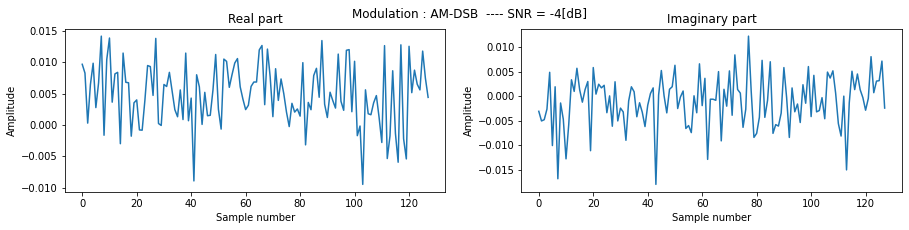

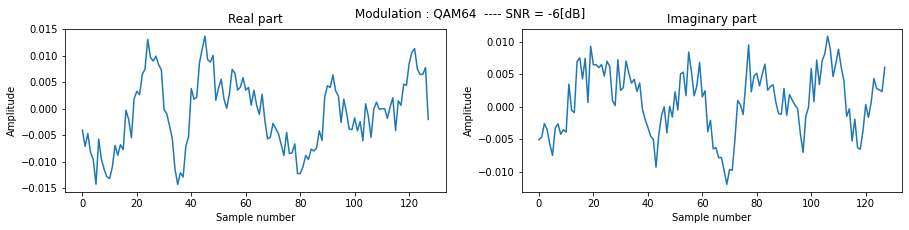

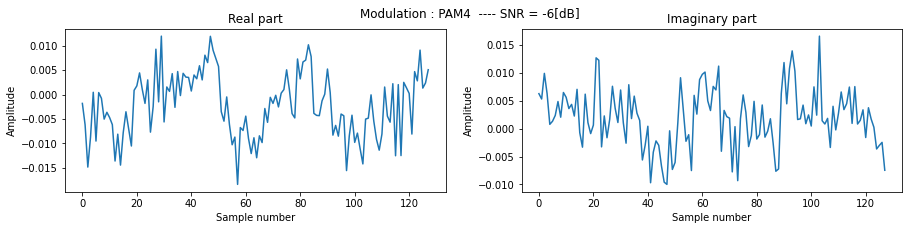

In [5]:
def plot_one_example(signal, label='', snr = -100):
  # Plot one example
  t = np.linspace(0, 127, 128)
  real_part = signal[0,:]
  imag_part = signal[1,:]

  plt.figure(figsize=(15, 3))

  plt.subplot(121)
  plt.plot(t, real_part), plt.xlabel('Sample number'), plt.ylabel('Amplitude'), plt.title('Real part')

  plt.subplot(122)
  plt.plot(t, imag_part), plt.xlabel('Sample number'), plt.ylabel('Amplitude'), plt.title('Imaginary part')

  plt.suptitle('Modulation : ' + label +'  ---- SNR = ' + str(snr) + '[dB]')
  plt.show()

def plot_few_examples(signals, labels, snrs):
  t = np.linspace(0, 127, 128)
  num_examples = signals.shape[0]
  for i in range(num_examples):
      plot_one_example(signals[i,:,:],labels[i], snrs[i])

num_examples = 3
examples_number_vec = random.sample(range(0, int(n_train-1)), num_examples)
train_examples = X_train[examples_number_vec,:,:]
label_examples = Y_train[examples_number_vec]
label_examples = np.argmax(label_examples, axis=1)
mod_labels = [ mods[i] for i in label_examples]
snr_examples = [snr_train[i] for i in examples_number_vec]
plot_few_examples(train_examples, mod_labels, snr_examples)


# Define Model

## Architecture

In [112]:
# define the CNN architecture
class CNN1(nn.Module):
    def fc_block_1(self, in_features, out_features, use_batchnorm=True, use_dropout=False, dropout=0.25):
      layers = [nn.Linear(in_features=in_features, out_features=out_features)]

      layers.append(nn.ReLU())
      if use_batchnorm:
        layers.append(nn.BatchNorm2d(out_features))

      if use_dropout:
        layers.append(nn.Dropout(dropout))

      block = nn.Sequential(*layers)
      return block

    def fc_block_2(self, in_features, out_features):
      layers = [nn.Linear(in_features=in_features , out_features=out_features)]
      
      block = nn.Sequential(*layers)
      return block  

    def conv_block(self, in_channels, out_channels, kernel_size, padding, bias, use_batchnorm=True, use_dropout=False, dropout=0.25):
      layers = [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                          kernel_size=kernel_size, padding=padding, bias=bias)]

      layers.append(nn.ReLU())

      if use_batchnorm:
        layers.append(nn.BatchNorm2d(out_channels))
      
      if use_dropout:
        layers.append(nn.Dropout(dropout))
      
      block = nn.Sequential(*layers)
      return block

    def __init__(self, n_classes=10):
      super(CNN1, self).__init__()
      # SIZE : Batch x 1-channel x IQ x input_samples 
      # Modifying the first convolutional layer to not use a bias term is a
      # modification made by Bryse Flowers due to the observation of vanishing
      # gradients during training when ported to PyTorch

      self.conv_layer1 = self.conv_block(in_channels=1, out_channels=256, kernel_size=(1,7), padding=(0,3), bias=False)
      self.conv_layer2 = self.conv_block(in_channels=256, out_channels=80, kernel_size=(1,7), padding=(0,3), bias=False)
      self.conv_layer3 = self.conv_block(in_channels=80, out_channels=30, kernel_size=(2,7), padding=(0,3), bias=False)
   
      self.fc_layer1 = self.fc_block_1(in_features=30*1*128, out_features=256)
      self.fc_layer2 = self.fc_block_2(in_features=256, out_features=n_classes)
    
    def forward(self, x):

      # BATCH x 1 x 2 x 128
      x = self.conv_layer1(x)
      # BATCH x 256 x 2 x 128
      x = self.conv_layer2(x)
      # BATCH x 80 x 2 x 128
      x = self.conv_layer3(x)
      # BATCH x 30 x 1 x 128

      # Flatten the input layer down to 1-d by using Tensor operations
      x = x.contiguous()
      x = x.view(x.size()[0], -1)

      # Batch x Features = BATCH x 3840
      x = self.fc_layer1(x)
      # BATCH x 256
      x = self.fc_layer2(x)
      # BATCH x n_classes = BATCH x 10
      return x

# create a complete CNN
num_classes = 10
model = CNN1(num_classes).to(DEVICE)
print(model)


CNN1(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(80, 30, kernel_size=(2, 7), stride=(1, 1), padding=(0, 3), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layer1): Sequential(
    (0): Linear(in_features=3840, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layer2): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


## Loss & Optimizer

In [7]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train & Test Functions

# Plotting & Helper Functions